Preprocessing data...
Finding optimal number of clusters...


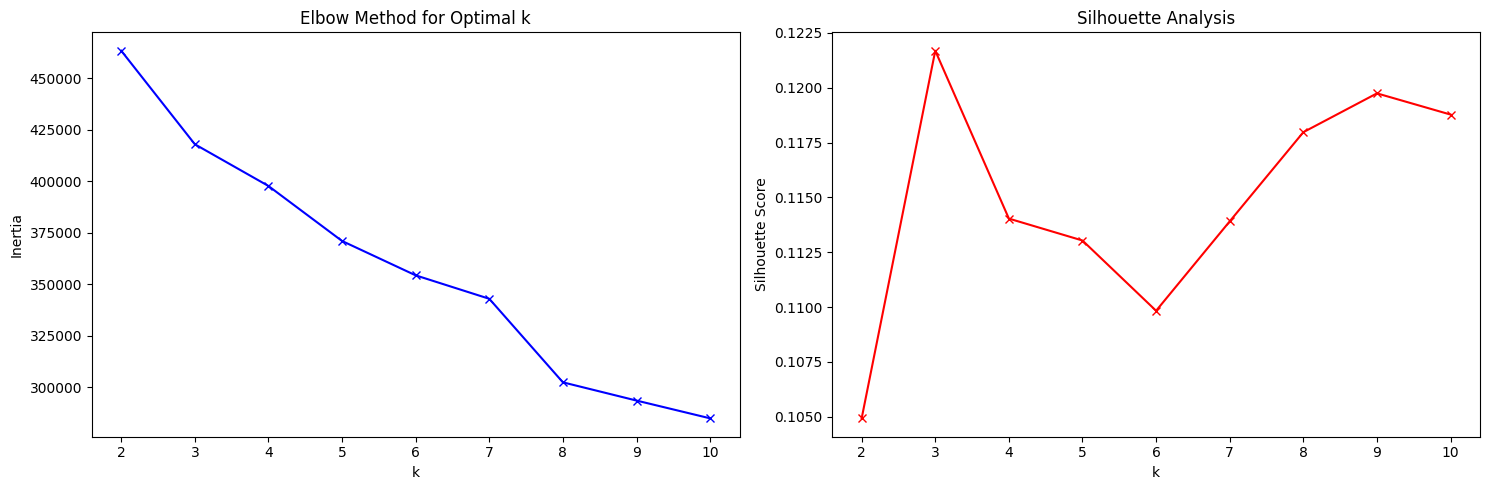

Performing K-means clustering...

Clustering Validation Metrics:
Silhouette Score: 0.122
Calinski-Harabasz Score: 5561.468

Analyzing cluster characteristics...

Cluster Sizes:
Cluster
0    21344
1    25261
2     2237
Name: count, dtype: int64

Cluster Statistics:
           age            fnlwgt            education-num       capital-gain  \
          mean    std       mean        std          mean   std         mean   
Cluster                                                                        
0        29.15   8.87  202680.17  114124.71          9.63  2.31       193.77   
1        46.39  12.05  178785.31   97104.70         10.38  2.71      1922.65   
2        41.78  12.90  188321.17   98988.41         11.00  2.64         0.00   

                  capital-loss         hours-per-week         
              std         mean     std           mean    std  
Cluster                                                       
0         1641.99         0.72   22.01          35.96  10.90  
1 

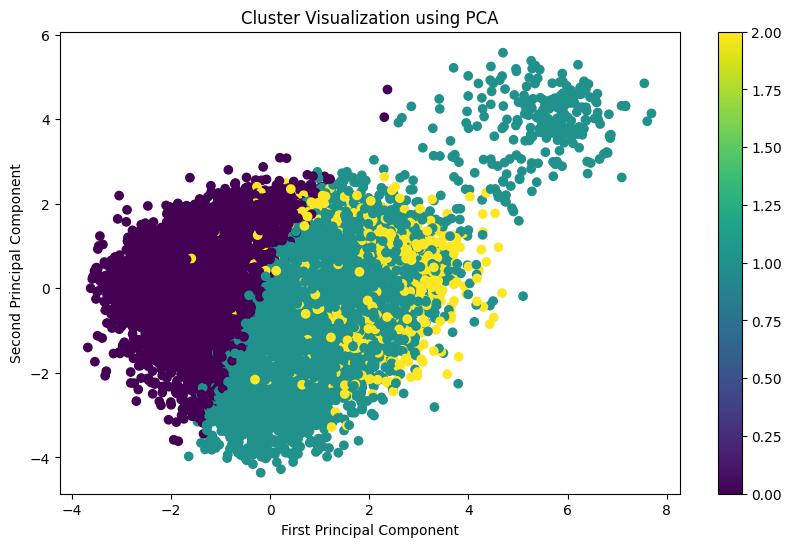


Analyzing feature distributions...


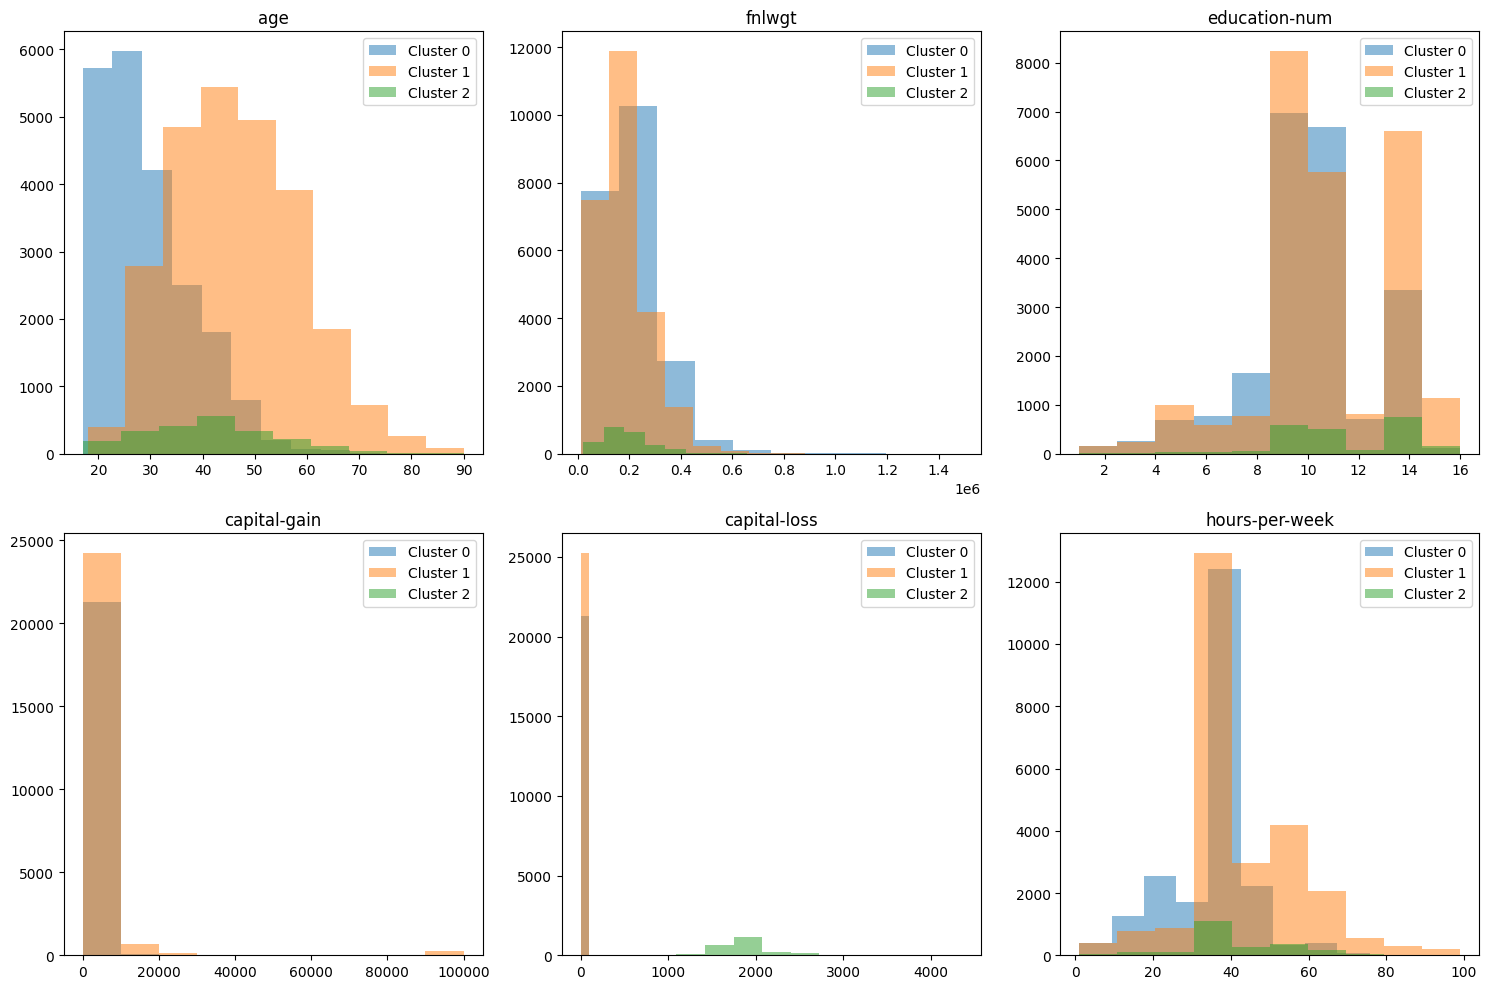

In [10]:
!pip install numpy pandas matplotlib seaborn scikit-learn ucimlrepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from ucimlrepo import fetch_ucirepo

class AdultClusteringAnalysis:
    def __init__(self):
        # Load data
        adult = fetch_ucirepo(id=2)
        self.X = adult.data.features
        self.y = adult.data.targets  # Not used for clustering, but can be useful later
        self.X_prepared = None
        self.kmeans_model = None
        self.labels = None

    def preprocess_data(self):
        """Preprocesses data using pipelines for better organization."""
        # Define categorical and numerical features
        categorical_features = self.X.select_dtypes(include=['object']).columns.tolist()
        numerical_features = self.X.select_dtypes(exclude=['object']).columns.tolist()

        # Create preprocessing pipelines
        categorical_pipeline = Pipeline([
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ])
        numerical_pipeline = Pipeline([
            ('scaler', StandardScaler())
        ])

        # Combine pipelines using ColumnTransformer
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_pipeline, numerical_features),
                ('cat', categorical_pipeline, categorical_features)
            ])

        # Fit and transform the data
        self.X_prepared = preprocessor.fit_transform(self.X)

        # Get feature names after OneHotEncoding (for better interpretability later)
        feature_names = numerical_features + list(preprocessor.named_transformers_['cat']['onehot']\
                                                 .get_feature_names_out(categorical_features))

        self.X_prepared = pd.DataFrame(self.X_prepared, columns=feature_names)
        return self.X_prepared

    def find_optimal_clusters(self, max_k=10):
        """Determines optimal number of clusters using elbow method and silhouette score."""
        inertias = []
        silhouette_scores = []
        k_range = range(2, max_k + 1)

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(self.X_prepared)  # Change here
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(self.X_prepared, kmeans.labels_))  # Change here

        # Plot results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Elbow curve
        ax1.plot(k_range, inertias, 'bx-')
        ax1.set_xlabel('k')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method for Optimal k')

        # Silhouette scores
        ax2.plot(k_range, silhouette_scores, 'rx-')
        ax2.set_xlabel('k')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Analysis')

        plt.tight_layout()
        plt.show()

        return inertias, silhouette_scores

    def perform_kmeans(self, n_clusters=3):
        """Performs K-means clustering."""
        self.kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
        self.labels = self.kmeans_model.fit_predict(self.X_prepared)  # Change this line
        return self.kmeans_model, self.labels

    def validate_clusters(self):
        """Validate clustering results using multiple metrics."""
        sil_score = silhouette_score(self.X_prepared, self.labels)  # Change this line
        ch_score = calinski_harabasz_score(self.X_prepared, self.labels)  # Change this line

        print("\nClustering Validation Metrics:")
        print(f"Silhouette Score: {sil_score:.3f}")
        print(f"Calinski-Harabasz Score: {ch_score:.3f}")

    def analyze_clusters(self):
        """Analyze characteristics of each cluster"""
        # Add cluster labels to original data
        cluster_df = self.X.copy()
        cluster_df['Cluster'] = self.labels

        # Calculate cluster sizes
        cluster_sizes = cluster_df['Cluster'].value_counts().sort_index()
        print("\nCluster Sizes:")
        print(cluster_sizes)

        # Calculate statistics for numerical features
        numerical_features = self.X.select_dtypes(include=['int64', 'float64']).columns
        cluster_stats = cluster_df.groupby('Cluster')[numerical_features].agg(['mean', 'std'])
        print("\nCluster Statistics:")
        print(cluster_stats.round(2))

    def visualize_clusters(self):
        """Creates visualizations of the clustering results."""
        # PCA for dimensionality reduction
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.X_prepared)  # Change this line

        # Plot clusters
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                            c=self.labels,
                            cmap='viridis')
        plt.colorbar(scatter)
        plt.title('Cluster Visualization using PCA')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.show()

    def analyze_feature_distributions(self):
        """Analyze feature distributions across clusters"""
        numerical_features = self.X.select_dtypes(include=['int64', 'float64']).columns
        n_features = len(numerical_features)

        fig, axes = plt.subplots(2, (n_features + 1) // 2, figsize=(15, 10))
        axes = axes.ravel()

        for idx, feature in enumerate(numerical_features):
            for cluster in np.unique(self.labels):
                cluster_data = self.X[self.labels == cluster][feature]
                axes[idx].hist(cluster_data, alpha=0.5, label=f'Cluster {cluster}')
            axes[idx].set_title(feature)
            axes[idx].legend()

        plt.tight_layout()
        plt.show()

def main():
    # Initialize analysis
    analysis = AdultClusteringAnalysis()

    # Preprocess data
    print("Preprocessing data...")
    analysis.preprocess_data()

    # Find optimal number of clusters
    print("Finding optimal number of clusters...")
    analysis.find_optimal_clusters()

    # Perform clustering
    print("Performing K-means clustering...")
    analysis.perform_kmeans(n_clusters=3)  # You can adjust the number of clusters

    # Validate clusters
    analysis.validate_clusters()

    # Analyze clusters
    print("\nAnalyzing cluster characteristics...")
    analysis.analyze_clusters()

    # Visualize results
    print("\nCreating visualizations...")
    analysis.visualize_clusters()

    # Analyze feature distributions
    print("\nAnalyzing feature distributions...")
    analysis.analyze_feature_distributions()

if __name__ == "__main__":
    main()
